FINALLY got it working, so now its just cleaned up & will implement for various deltas/selections/POIs. Keeping the other one again becuse the progress/info could be helpful.

In [8]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util_splitdelta as gu
import plot_util as pu

from scipy.interpolate import interp1d

import Week7_PFNutils as W

import convert_sets_splitdelta as cs

In [2]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
data_path = '/data/atlas/'

In [3]:
import vector as v

import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

v.register_awkward()

In [12]:
events = ur.open(model_path+'delta_medium.root')

tree = events['EventTree']

In [13]:
truthID = tree['truthPartPdgId'].array()

In [10]:
def makemask(truthID, deltaID, excludeID, POI, partID2):
    #have to specify 4 particles: the delta of interest, what to avoid, the particle of interest that will later
    #be used, and then the other one 
    
    selectedinds = []    

    for i in range(len(truthID)): #basically: delta+, two categories: pip & n (without any ps) vs pi0 & p (no ns)
        if (deltaID in truthID[i]) & ~(excludeID in truthID[i]) & (POI in truthID[i]) & (partID2 in truthID[i]):
            selectedinds.append(i)

    flag = np.zeros(len(truthID))
    flag[selectedinds] = 2
    
    mask = flag == 2
    
    return mask

In [7]:
mask = makemask(truthID, 2214, 2212, 2112, 211) #delta+, no ps, POI = n, also pi+s

In [8]:
cs.doit_cc(mask, data_path+'w12_closestcluster', 211, 2112)

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 211
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster


In [9]:
#then do data processing:
file = np.load(data_path+'w12_closestcluster.npz')

X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']

In [18]:
len(X)

7357

In [19]:
W.datatofile((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster.npz', 7357)

In [4]:
NNfile = np.load(data_path+'nn_closestcluster.npz')
model_nog = tf.keras.models.load_model(model_path+'w8_pfn_noglob_2.hdf5')

2021-07-27 12:56:29.453033: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 91328000 exceeds 10% of free system memory.
2021-07-27 12:56:29.552384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-27 12:56:29.571744: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2021-07-27 12:56:29.760238: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-27 12:56:33.147952: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-07-27 12:56:35.036294: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 91328000 exceeds 10% of free system memory.


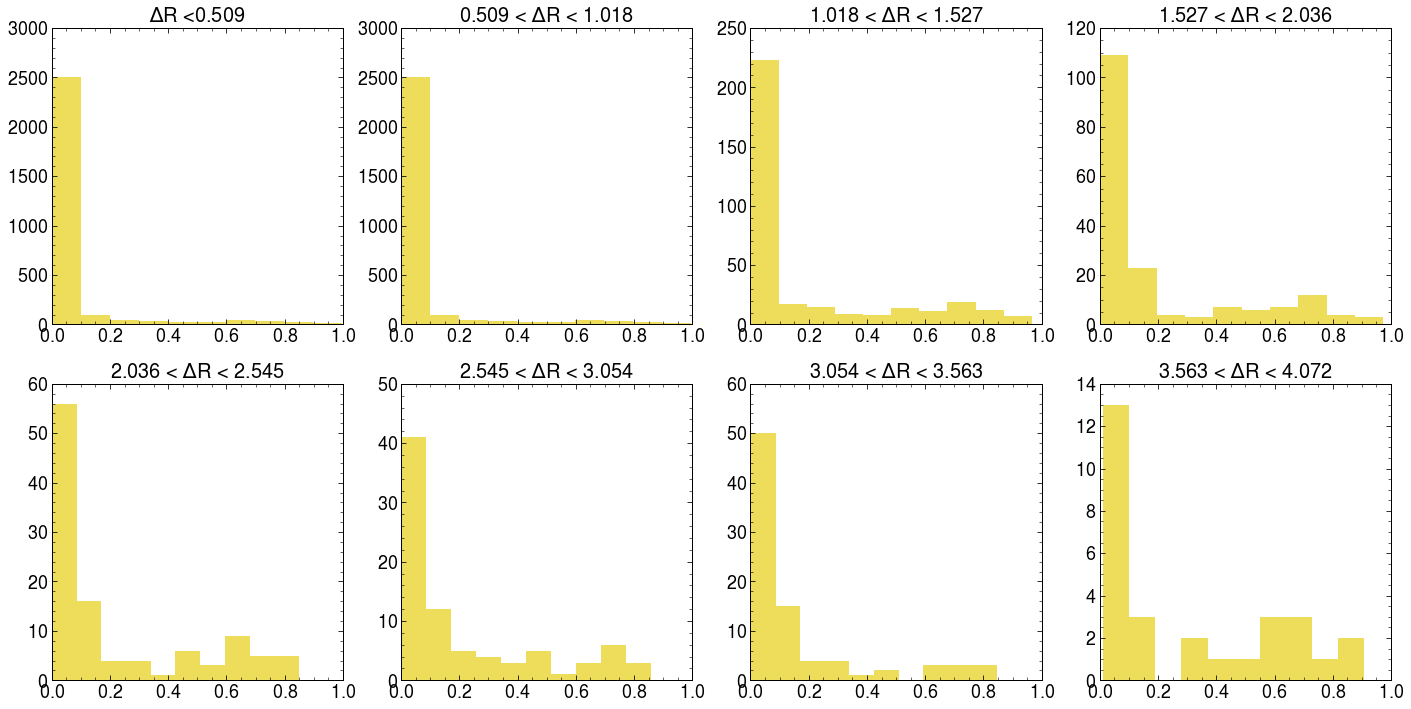

In [5]:
W.deltaR_responseplots(NNfile, model_nog, col='xkcd:dull yellow') #delta+, no ps, POI = n, also pi+s

In [22]:
mask_0p = makemask(truthID, 2214, 2112, 2212, 111) #delta+, no ns, POI = pi0, also ps

In [24]:
cs.doit_cc(mask_0p, data_path+'w12_closestcluster_pi0', 111, 2212)

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_pi0


In [25]:
#then do data processing:
file0 = np.load(data_path+'w12_closestcluster_pi0.npz')

X0 = file0['X']
clus_eta0 = file0['clus_eta']
clus_pt0 = file0['clus_pt']
clus_E0 = file0['clus_e']
clus_et0 = file0['clus_e_t']
deltar0 = file0['deltaR']

In [26]:
len(X0)

15385

In [27]:
W.datatofile((X0, clus_eta0, clus_pt0, clus_E0, clus_et0, deltar0), 'nn_closestcluster_pi0.npz', len(X0))

In [6]:
NNfile0 = np.load(model_path+'nn_closestcluster_pi0.npz')

2021-07-27 12:57:15.844026: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 191456000 exceeds 10% of free system memory.
2021-07-27 12:57:23.145343: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 191456000 exceeds 10% of free system memory.


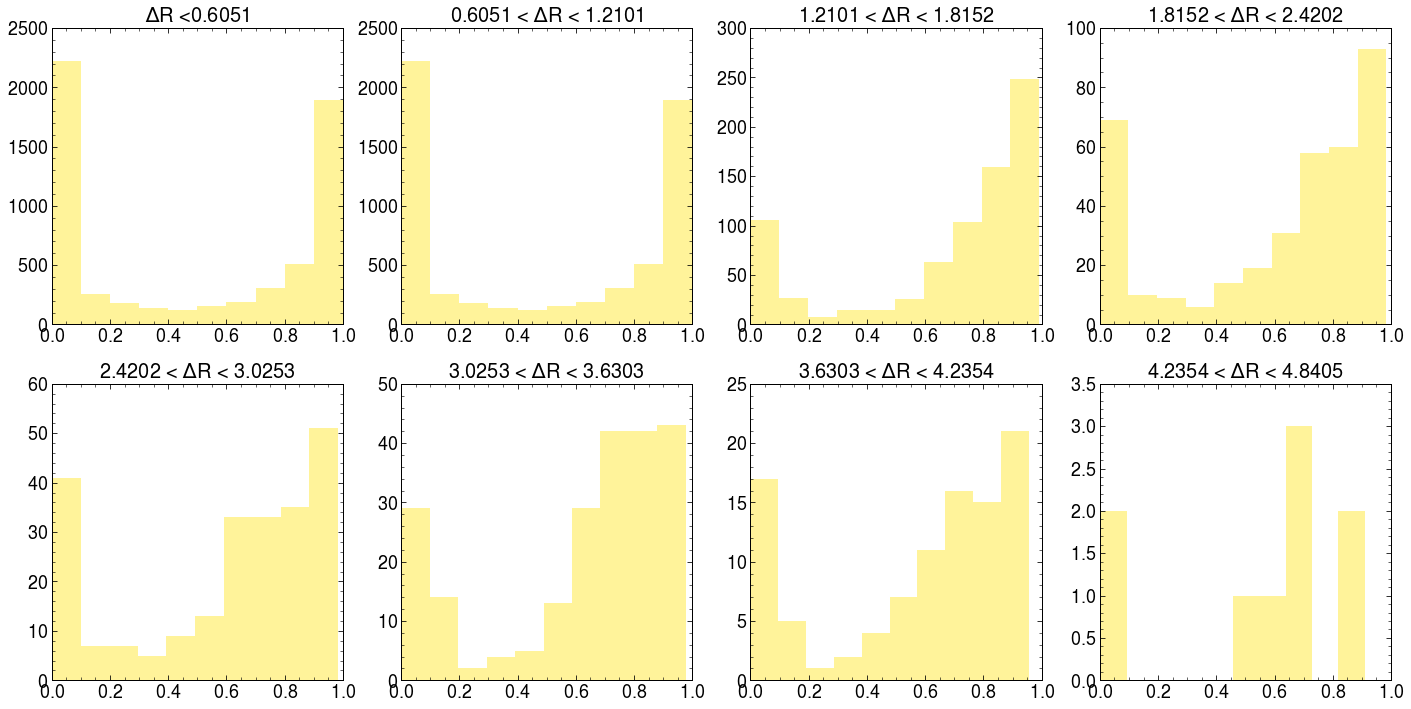

In [7]:
W.deltaR_responseplots(NNfile0, model_nog, col='xkcd:dark cream') #delta+, no ns, POI = pi0, also ps

In [14]:
# try for delta0??
mask_del0 = makemask(truthID, 2114, 2112, 2212, -211) #delta0, no ns, POI = pi-, also ps

cs.doit_cc(mask_del0, data_path+'w12_closestcluster_del0pi-', -211, 2212)

#then do data processing:
filed0 = np.load(data_path+'w12_closestcluster_del0pi-.npz')

Xd0 = filed0['X']
clus_etad0 = filed0['clus_eta']
clus_ptd0 = filed0['clus_pt']
clus_Ed0 = filed0['clus_e']
clus_etd0 = filed0['clus_e_t']
deltard0 = filed0['deltaR']

W.datatofile((Xd0, clus_etad0, clus_ptd0, clus_Ed0, clus_etd0, deltard0), 'nn_closestcluster_del0pi-.npz', len(Xd0))

NNfile0 = np.load(model_path+'nn_closestcluster_del0pi-.npz')

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle -211
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster_del0pi-


2021-07-27 13:24:16.187626: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 96800000 exceeds 10% of free system memory.


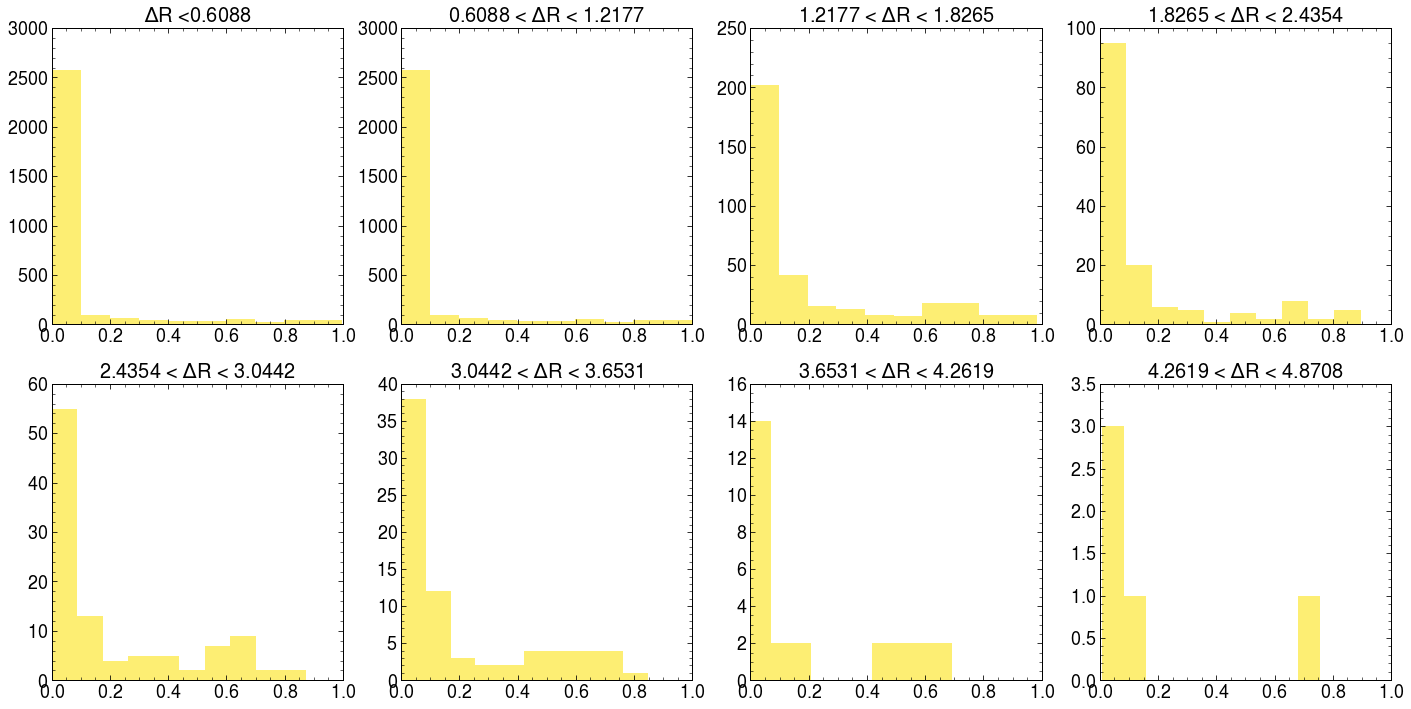

In [15]:
W.deltaR_responseplots(NNfile0, model_nog, col='xkcd:sandy yellow') #delta0, no ns, POI = pi-, also ps

In [16]:
mask_del0p0 = makemask(truthID, 2114, 2212, 2112, 111) #delta0, no ps, POI = pi0, also ns

cs.doit_cc(mask_del0p0, data_path+'w12_closestcluster_del0pi0', 111, 2112)

#then do data processing:
filed0p0 = np.load(data_path+'w12_closestcluster_del0pi0.npz')

Xd0p0 = filed0p0['X']
clus_etad0p0 = filed0p0['clus_eta']
clus_ptd0p0 = filed0p0['clus_pt']
clus_Ed0p0 = filed0p0['clus_e']
clus_etd0p0 = filed0p0['clus_e_t']
deltard0p0 = filed0p0['deltaR']

W.datatofile((Xd0p0, clus_etad0p0, clus_ptd0p0, clus_Ed0p0, clus_etd0p0, deltard0p0), 'nn_closestcluster_del0pi0.npz', len(Xd0p0))

NNfiled0p0 = np.load(model_path+'nn_closestcluster_del0pi0.npz')

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_del0pi0


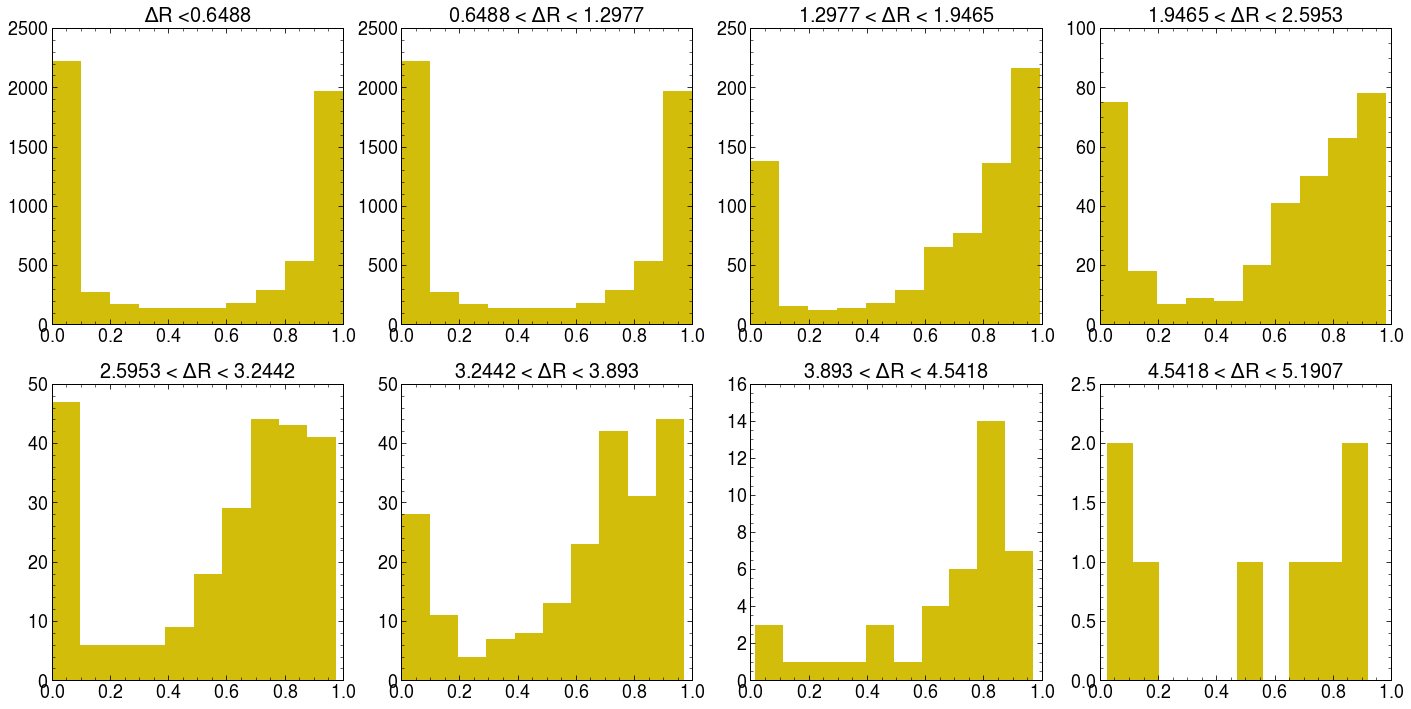

In [17]:
W.deltaR_responseplots(NNfiled0p0, model_nog, col='xkcd:mustard yellow') #delta0, no ps, POI = pi0, also ns